In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.preprocessing import OrdinalEncoder
import pywt

from google.colab import drive

drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
df1 = pd.read_csv('/content/drive/MyDrive/Apple_Stock_yahoo.csv')
enc = OrdinalEncoder()
df2 = pd.read_csv('/content/drive/MyDrive/Apple_Sentiment.csv')
df2[['Sent']] = enc.fit_transform(df2[['Sent']])
df = pd.merge(df1, df2, on='Date')
df

,Date,Close,Unnamed: 0,Sent
0,2023-01-03,125.070000,0,1.0
1,2023-01-04,126.360001,1,1.0
2,2023-01-05,125.019997,2,2.0
3,2023-01-06,129.619995,3,2.0
4,2023-01-09,130.149994,4,1.0
...,...,...,...,...
275,2024-02-09,188.850006,275,1.0
276,2024-02-12,187.149994,276,1.0
277,2024-02-13,185.039993,277,1.0
278,2024-02-14,184.149994,278,1.0


In [ ]:


df = df.sort_values('Date')
ema_period = 14
df['EMA'] = df['Close'].ewm(span=ema_period, adjust=False).mean()

df['Price Change'] = df['Close'].diff()
df['Gain'] = df['Price Change'].apply(lambda x: x if x > 0 else 0)
df['Loss'] = df['Price Change'].apply(lambda x: abs(x) if x < 0 else 0)


df['Avg Gain'] = df['Gain'].ewm(span=ema_period, adjust=False).mean()
df['Avg Loss'] = df['Loss'].ewm(span=ema_period, adjust=False).mean()

df['RS'] = df['Avg Gain'] / df['Avg Loss']


df['RSI'] = 100 - (100 / (1 + df['RS']))


df.drop(['Price Change', 'Gain', 'Loss', 'Avg Gain', 'Avg Loss', 'RS'], axis=1, inplace=True)


df = df.dropna()


data = df[['Close','EMA','Sent']].values.reshape(-1, 1)


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

sequence_length = 10
X, y = [], []

for i in range(len(scaled_data) - sequence_length):
    X.append(scaled_data[i:i + sequence_length, :].reshape(-1))
    y.append(scaled_data[i + sequence_length, 0])

X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')


history = model.fit(X_train, y_train, epochs=100, batch_size=32)

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

Epoch 1/100
21/21 [==============================] - 11s 73ms/step - loss: 0.2741
Epoch 2/100
21/21 [==============================] - 1s 61ms/step - loss: 0.1827
Epoch 3/100
21/21 [==============================] - 1s 55ms/step - loss: 0.1812
Epoch 4/100
21/21 [==============================] - 1s 59ms/step - loss: 0.1781
Epoch 5/100
21/21 [==============================] - 1s 59ms/step - loss: 0.1817
Epoch 6/100
21/21 [==============================] - 1s 53ms/step - loss: 0.1785
Epoch 7/100
21/21 [==============================] - 1s 50ms/step - loss: 0.1788
Epoch 8/100
21/21 [==============================] - 1s 59ms/step - loss: 0.1776
Epoch 9/100
21/21 [==============================] - 2s 76ms/step - loss: 0.1844
Epoch 10/100
21/21 [==============================] - 2s 95ms/step - loss: 0.1816
Epoch 11/100
21/21 [==============================] - 1s 68ms/step - loss: 0.1780
Epoch 12/100
21/21 [==============================] - 1s 47ms/step - loss: 0.1884
Epoch 13/100
21/21 [====

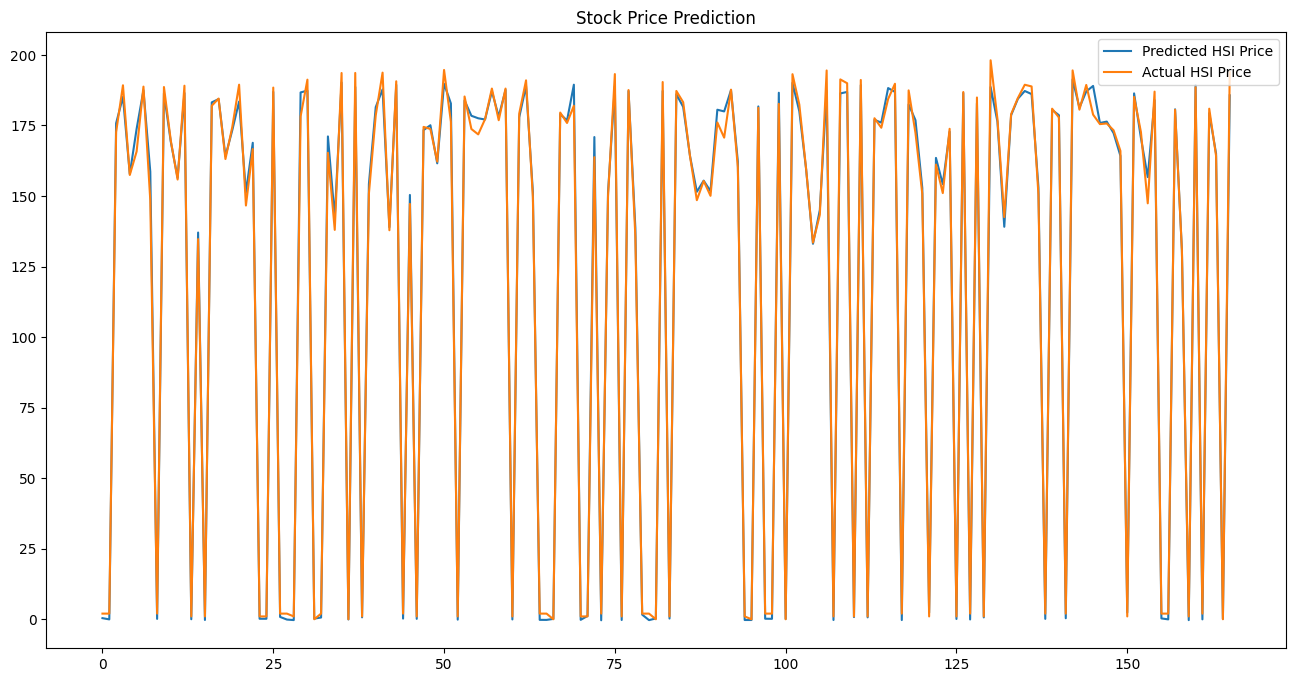

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(predictions, label='Predicted HSI Price')
plt.plot(y_test_original, label='Actual HSI Price')
plt.legend()
plt.title('Stock Price Prediction')
plt.show()